In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dataset_folder = "dataset/cleaned"
sensor_name = "Sensor 1"
save_folder = f"saved_model/{sensor_name}"

In [3]:
train_data = pd.read_csv(
    f"{dataset_folder}/train/{sensor_name}_train.csv"
)
val_data = pd.read_csv(
    f"{dataset_folder}/val/{sensor_name}_val.csv"
)
test_data = pd.read_csv(
    f"{dataset_folder}/test/{sensor_name}_test.csv"
)

train_data["created_at"] = pd.to_datetime(train_data["created_at"], format="ISO8601")
val_data["created_at"] = pd.to_datetime(val_data["created_at"], format="ISO8601")
test_data["created_at"] = pd.to_datetime(test_data["created_at"], format="ISO8601")

train_data.set_index("created_at", inplace=True)
val_data.set_index("created_at", inplace=True)
test_data.set_index("created_at", inplace=True)

In [4]:
train_data = train_data[['power']]
val_data = val_data[['power']]
test_data = test_data[['power']]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [5]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [6]:
X_train, y_train = create_sequences(train_data_scaled, time_steps=24)
X_val, y_val = create_sequences(val_data_scaled, time_steps=24)
X_test, y_test = create_sequences(test_data_scaled, time_steps=24)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [7]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/daffa/Projects/Final Project/final-project-model/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/2
42947/42947 ━━━━━━━━━━━━━━━━━━━━ 261s 6ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 2/2
42947/42947 ━━━━━━━━━━━━━━━━━━━━ 277s 6ms/step - loss: 0.0013 - val_loss: 0.0018


In [9]:
model.export(save_folder)

INFO:tensorflow:Assets written to: saved_model/Sensor 1/assets


INFO:tensorflow:Assets written to: saved_model/Sensor 1/assets


Saved artifact at 'saved_model/Sensor 1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5964910416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5964911184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5964912144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5964912720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5964913488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5964913872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5964911952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5964914256: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

10181/10181 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Mean Squared Error (MSE): 791.8661
Mean Absolute Error (MAE): 4.4507
Root Mean Squared Error (RMSE): 28.1401
R² Score: 0.9894


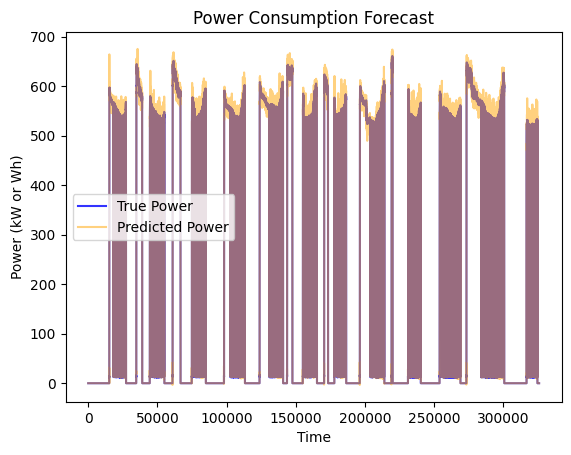

In [11]:
plt.plot(y_test_rescaled, label='True Power', color='blue', alpha=0.8)
plt.plot(y_pred_rescaled, label='Predicted Power', color='orange', alpha=0.5)
plt.legend()
plt.title("Power Consumption Forecast")
plt.xlabel("Time")
plt.ylabel("Power (kW or Wh)")
plt.show()

In [18]:
result_df = pd.DataFrame({
    'time': test_data.index[24:].strftime('%Y-%m-%dT%H:%M:%S'),
    'predicted_power': y_pred_rescaled.flatten(),
    'actual_power': y_test_rescaled.flatten(),
})

In [27]:
result_df['time'] = pd.to_datetime(result_df['time'], format="ISO8601")
result_df['date'] = result_df['time'].dt.date
daily_counts = result_df.groupby(['date']).size().reset_index(name='count')
daily_counts["date"] = daily_counts["date"].astype(str)

dates = []
predicted_energy = []
actual_energy = []

for _, row in daily_counts.iterrows():
    date = row["date"]
    
    sensor_data = result_df[result_df["date"] == pd.to_datetime(date).date()]
    sensor_data = sensor_data.sort_values(by="time")
    
    sensor_data["time_diff"] = sensor_data["time"].diff().dt.total_seconds()
    average_interval = sensor_data["time_diff"].mean()
    
    total_energy_predicted = 0
    total_energy_actual = 0
    for _, row in sensor_data.iterrows():
        predicted_power = row["predicted_power"]
        actual_power = row["actual_power"]
        interval = average_interval / 3600

        predicted_energy_value = (predicted_power * interval) / 1000
        total_energy_predicted += predicted_energy_value

        actual_energy_value = (actual_power * interval) / 1000
        total_energy_actual += actual_energy_value

    dates.append(date)
    predicted_energy.append(total_energy_predicted)
    actual_energy.append(total_energy_actual)

    print(f"Different energy consumption ({date}):", total_energy_actual - total_energy_predicted)

Different energy consumption (2024-11-10): -0.010370832551911846
Different energy consumption (2024-11-11): -0.018264622697085287
Different energy consumption (2024-11-12): -0.022487890978916347
Different energy consumption (2024-11-13): -0.007531191392414094
Different energy consumption (2024-11-14): -0.013146293363777595
Different energy consumption (2024-11-15): -0.024208342382689985
Different energy consumption (2024-11-16): -0.014248164026435362
Different energy consumption (2024-11-17): -0.002001514007822891
Different energy consumption (2024-11-18): -0.024100319097733358
Different energy consumption (2024-11-19): -0.02094036366526808
Different energy consumption (2024-11-20): -0.04348096154139647
Different energy consumption (2024-11-21): -0.015577826506000036


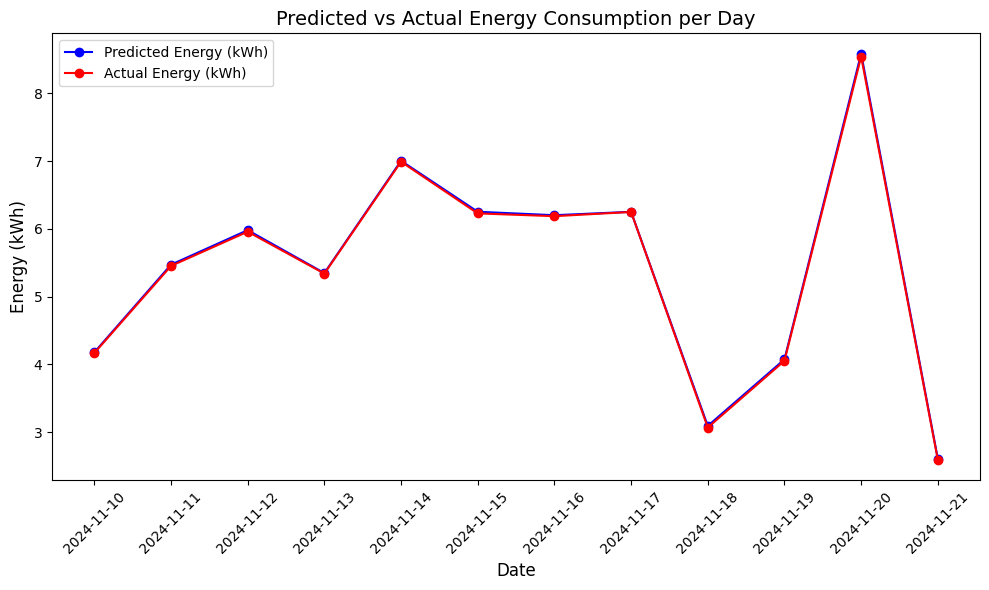

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_energy, label="Predicted Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.plot(dates, actual_energy, label="Actual Energy (kWh)", marker='o', linestyle='-', color='red')
plt.title("Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()